<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

## Practice Solution Notebook 

<h3>Topics Covered </h3>

-  Decision Tree
-  Random Forest
-  Bagging
-  Boosting
-  Stacking




## Dataset Description

The dataset can be found [here](https://www.kaggle.com/pratyushakar/rossmann-store-sales?select=train.csv)

Domain: Marketing, Sales

### Features:

- Store: Unique Id for each store

- DayOfWeek: Day of the week

- Date: Date of the insance

- Sales: Turnover on that day (Target feature)

- Customers: Number of customers on that given day

- Open: Indicator for whether the store was open. Where, 0 = closed, 1 = open

- Promo: Indicates whether a store is running a promo on that day

- StateHoliday:  Indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. Where, a = public holiday, b = Easter holiday, c = Christmas, 0 = None

- SchoolHoliday: Indicates if there was closure of public schools



<h3>1. Import necessary libraries. </h3>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [63]:
import numpy as np
import re
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial as f


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib.font_manager import FontProperties
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from mlxtend.regressor import StackingRegressor

<h3>2.Load the training data and display a sample of five rows of the data frame..</h3>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_csv('/content/drive/MyDrive/train.csv')

In [6]:
df.sample(n=5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
368492,335,2,2014-08-12,11255,2239,1,0,0,1
539215,341,3,2014-03-05,7968,922,1,1,0,0
126918,924,4,2015-04-09,4054,426,1,0,0,1
938704,660,2,2013-03-12,3738,447,1,0,0,0
902796,432,6,2013-04-13,6852,992,1,0,0,0


<h3>3. Check the shape of the data (number of rows and column). Check the general information about the dataframe using .info() method.
</h3>

In [7]:
def basic_info(df):
    '''checking basic information & shape about the dataframe'''
    print("Shape of the dataset",df.shape)
    print("*"*30)
    print(df.info())
    
basic_info(df)

Shape of the dataset (1017209, 9)
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None


* There are around 1 million instances and 9 features
* There seems to be no null values
* StateHoliday is of type object but in the above sample we can see that there are also numeric values. We will have to check this column and fix it
* "Date" column is like the index for our dataset, we will drop this feature, but we can try to create new features from it.

<h3>4.Check the percentage of missing values in each column of the data frame. Drop the missing values if there are any</h3>

In [8]:
def check_missing_values(df):
    '''Function to check the missing data percentage'''
    print("percentage of missing data of dataframe \n",df.isnull().sum()/len(df)*100)
    
check_missing_values(df)

percentage of missing data of dataframe 
 Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64


* As we saw earlier there are no null values

<h3> 5. Check if there are any duplicate rows.</h3>

In [9]:
def check_duplicate(df):
    duplicate=df[df.duplicated()]
    return duplicate

duplicate=check_duplicate(df)
duplicate

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


* We can see there are no duplicate values

<h3> 6. Check and convert the column StateHoliday to numeric </h3>

In [10]:
df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

* We can treat the holiday as ordinal data (for example categorizing holidays by popularity) as no_holiday is already 0, we can set public holidays (a)=1, Easter (b)=2, and Christmas (c)=3



In [11]:
df['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [12]:
holiday_map = {'0':0, 'a':1, 'b':2, 'c':3, 0:0}
df['StateHoliday'] = df['StateHoliday'].map(holiday_map)
df['StateHoliday'].unique()

array([0, 1, 2, 3])

<h3> 7. Create a new feature 'recency' from the 'Date' column</h3>
where,

- Recency = number of days between the end date and the current date

- Also drop the columns 'Date' and 'Store'

In [13]:
df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'].max())

2015-07-31 00:00:00


In [14]:
end_date = df['Date'].max()

In [15]:
df['Recency'] = df['Date'].apply(lambda x:(end_date-x).days)

In [16]:
df['Recency'].sample(5)

57559      51
298179    278
937640    870
461626    443
538118    512
Name: Recency, dtype: int64

In [17]:
df.drop(labels=['Date','Store'], axis=1, inplace=True)
df.sample(5)

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Recency
380228,4,9627,813,1,1,0,1,365
112882,2,3156,466,1,0,0,0,101
331727,7,0,0,0,0,0,0,313
852878,2,8044,707,1,1,0,0,794
523771,3,8033,630,1,1,0,0,499


<h3> 8. Check the basic statistics of the data-frame using describe() method. </h3>

In [18]:
def basic_statistics(df):
    return df.describe().T

basic_statistics(df)

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
StateHoliday,1017209.0,0.045163,0.283656,0.0,0.0,0.0,0.0,3.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
Recency,1017209.0,475.937004,274.454107,0.0,231.0,485.0,713.0,941.0


* The 'Store' column contains store id, in which we are not interested so we will drop that column
* Features like 'Sales' and 'Customers' seems to be right skewed with the presence of outliers
* 'Recency' seems to be normally distributed
* Features like 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday' contain binary values

<h3> 9. Visualize the distribution of data in column 'Sales', 'Customers', and 'Recency'</h3>

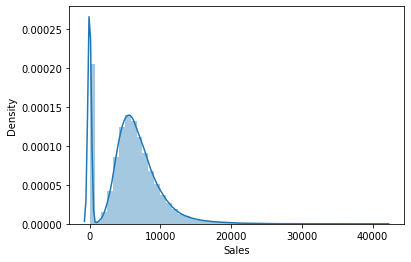

In [19]:
sns.distplot(df['Sales'])

* Sales is zero for a lot of days (These must be the days when the store was closed (holidays)). Also there seems to be huge outliers.


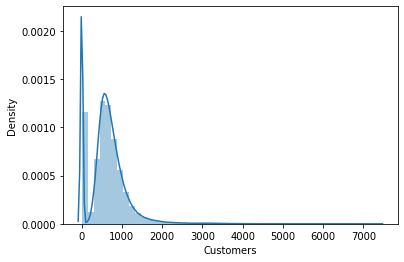

In [20]:
sns.distplot(df['Customers'])

* Here also we see a similar distribution


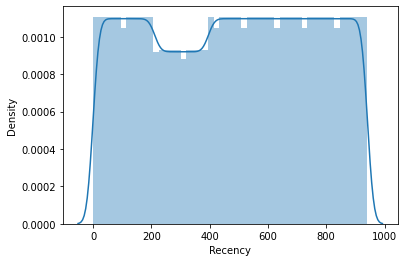

In [21]:
sns.distplot(df['Recency'])

* The recency data is uniformly distributed

<h3>10. Plot box plot to visualize the outliers in the column 'Sales' and 'Customers'
</h3>

- Also check if having a promo offer has effect on Sales

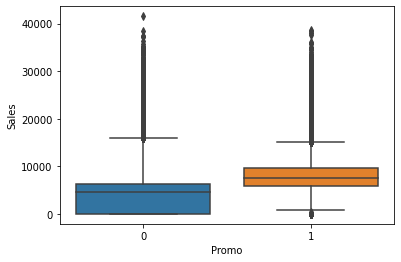

In [22]:
sns.boxplot(y='Sales', x=df['Promo'],data=df)

- We can clearly see that Sales are higher for the days when stores have a promotional offer

In [23]:
len(df[df['Sales']>20000])/len(df)

0.004029653689654732

Only 0.4% of the data have Sales more than 20000. We can remove these instances later after analysing the data

<h3>11. Lets visualize if DayOfWeek have any effect on Sales
</h3>

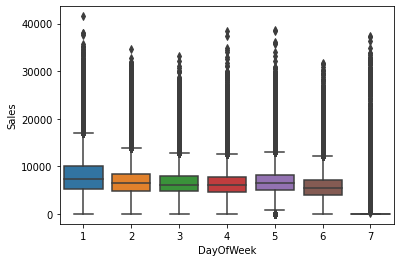

In [24]:
sns.boxplot(y='Sales', x=df['DayOfWeek'],data=df)

<h3>12. Lets visualize if State holidays have any effect on Sales
</h3>

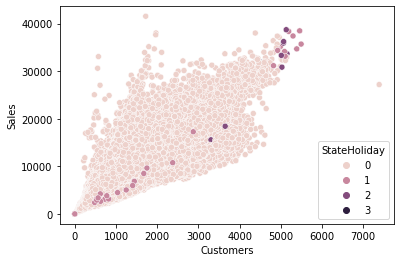

In [25]:
sns.scatterplot(x= 'Customers', y= 'Sales', hue='StateHoliday', data=df)

* We can see more popular holidays have higher sales


<h3>13.Lets remove the instances having outlier in Sales column</h3>

- drop the instances having Sales>20000


In [27]:
df = df[df['Sales']<20000]

<h3>14.Handle the outliers in Customer column</h3>




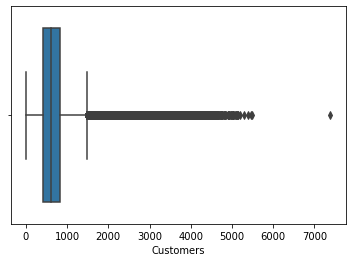

In [26]:
sns.boxplot(df['Customers'])

In [28]:
len(df[df['Customers']>2500])/len(df)

0.0050221644462737965

In [29]:
df = df[df['Customers']<2500]

<h3>15.Check the correlation among features</h3>



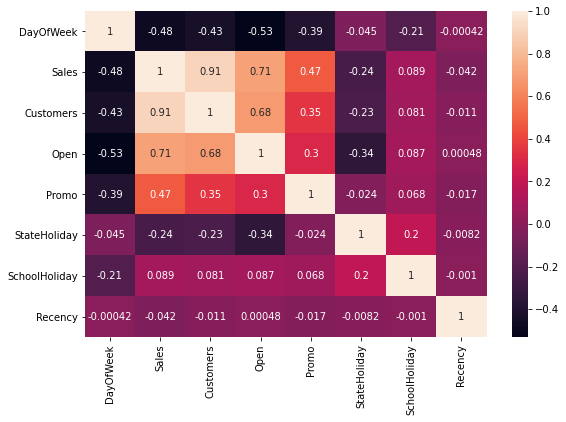

In [30]:
plt.figure(figsize=(9,6))
sns.heatmap(df.corr(),annot=True)

- The feature 'Recency' which we created does not have high correlation with Sales

<h1>Model Building and Evaluation </h1>

<h3>1. Store the target column (i.e.Response) in the y variable and the rest of the columns in the X variable.</h3>

In [31]:
y=df['Sales']
X = df.drop(['Sales'],axis=1)


<h3>2.Split the dataset into two parts (i.e. 70% train and 30% test) using random_state=42. </h3>

In [32]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.3,random_state=42)

<h3> 3.Train a Decision tree model </h3>


In [38]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
y_test_pred = dt.predict(X_test)
y_train_pred = dt.predict(X_train)

In [41]:
print("Train R2_score",r2_score(y_train,y_train_pred))
print("Test R2_score",r2_score(y_test,y_test_pred))

Train Accuracy 0.9728300093178355
Test Accuracy 0.7836629792275156


* We can see the model is over-fitted. Lets try to prune it.

<h3> 4. Train multiple Decision tree models with different values for max_depth and max_features </h3>


In [44]:
max_depth = [3,5,7]
max_features = [3,5,7]
for i in max_depth:
  for j in max_features:
    dt = DecisionTreeRegressor(max_depth = i, max_features=j)
    dt.fit(X_train,y_train)
    y_test_pred = dt.predict(X_test)
    y_train_pred = dt.predict(X_train)
    print(f"Train R2_score with max_depth = {i}, max_feature = {j}",r2_score(y_train,y_train_pred))
    print(f"Test R2_score with max_depth = {i}, max_feature = {j}",r2_score(y_test,y_test_pred))
    print("-"*20)

Train R2_score with max_depth = 3, max_feature = 3 0.7740299012284438
Test R2_score with max_depth = 3, max_feature = 3 0.7741529119960695
--------------------
Train R2_score with max_depth = 3, max_feature = 5 0.8178267488784238
Test R2_score with max_depth = 3, max_feature = 5 0.8185011315225474
--------------------
Train R2_score with max_depth = 3, max_feature = 7 0.817836766877747
Test R2_score with max_depth = 3, max_feature = 7 0.8185085210291195
--------------------
Train R2_score with max_depth = 5, max_feature = 3 0.7344567039121679
Test R2_score with max_depth = 5, max_feature = 3 0.7341077052629126
--------------------
Train R2_score with max_depth = 5, max_feature = 5 0.860609381345405
Test R2_score with max_depth = 5, max_feature = 5 0.8607730165980308
--------------------
Train R2_score with max_depth = 5, max_feature = 7 0.8613153432776053
Test R2_score with max_depth = 5, max_feature = 7 0.8615328620210863
--------------------
Train R2_score with max_depth = 7, max_fea

* We can see we are getting the best R2_score using max_depth = 7 and max_feature = 7

<h3> 5. Check the importance of features as per the Decision Tree  </h3>


In [47]:
pd.Series(dt.feature_importances_, index = X_train.columns)

DayOfWeek        8.008482e-03
Customers        9.631919e-01
Open             0.000000e+00
Promo            2.874290e-02
StateHoliday     7.389554e-08
SchoolHoliday    0.000000e+00
Recency          5.662158e-05
dtype: float64

Customers, Promo, DayOfWeek were found as the best features

<h3> 6.Train a Random Forest model </h3>


In [49]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

In [51]:
print("Train R2_score",r2_score(y_train,y_train_pred))
print("Test R2_score",r2_score(y_test,y_test_pred))

Train R2_score 0.9611561746368227
Test R2_score 0.853864183990622


* Here also we can see the model is bit over-fitted. 

In [52]:
print(rf)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


* Later you can try to fix the random forest model using different sets of hyper-parameters

<h3> 7.Train an Ada-boost Regressor model </h3>


In [58]:
ada = AdaBoostRegressor(base_estimator=dt, random_state=7, learning_rate=0.1)
ada.fit(X_train,y_train)
y_test_pred = ada.predict(X_test)
y_train_pred = ada.predict(X_train)

In [59]:
print(ada)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=7,
                                                       max_features=7,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  lea

In [60]:
print("Train R2_score",r2_score(y_train,y_train_pred))
print("Test R2_score",r2_score(y_test,y_test_pred))

Train R2_score 0.873984358238364
Test R2_score 0.8735207798166866


* There is no significant improvement, but we can try different base estimators(maybe more simple models) and try with other set of hyper-parameters

<h3>8. Train a Stacking Regressor model.</h3>
 


In [65]:
sr = StackingRegressor(regressors=[LinearRegression(),DecisionTreeRegressor(max_depth=7),AdaBoostRegressor()],
                       meta_regressor = RandomForestRegressor(n_estimators=30))
sr

StackingRegressor(meta_regressor=RandomForestRegressor(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=30,
                     

In [66]:
sr.fit(X_train,y_train)
y_test_pred = sr.predict(X_test)
y_train_pred = sr.predict(X_train)

In [67]:
print("Train R2_score",r2_score(y_train,y_train_pred))
print("Test R2_score",r2_score(y_test,y_test_pred))

Train R2_score 0.9566257784191792
Test R2_score 0.8305635743137404


* This model also seems to be overfitted


## Summary

This dataset seems to be prone to overfit. And thus performed well on simpler models 

## Further Exploration
Try different sets of parameters with the model to achieve better performance